In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install -U keras-efficientnet-v2

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Input, GlobalAveragePooling2D, Reshape, Lambda,  LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
import keras_efficientnet_v2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras import backend as K
import time
time.clock = time.time
import os

In [ ]:
train_data_dir = '/content/drive/My Drive/AI/train'
test_data_dir = '/content/drive/My Drive/AI/test'
batch_size = 32
image_height = 256
image_width = 256
number_of_class = 38
number_of_channel = 3
learning_rate = 0.001
epochs = 10

In [ ]:
os.listdir(train_data_dir)
DATA_CLASSES = ['chaparral', 'coastal_mansion', 'bridge', 'baseball_field', 'closed_road', 'cemetery', 'basketball_court', 'beach', 'airplane', 'christmas_tree_farm', 'mobile_home_park',
 'football_field', 'intersection', 'crosswalk', 'ferry_terminal', 'forest', 'harbor', 'freeway', 'golf_course', 'dense_residential', 'runway_marking', 'parking_lot',
 'railway', 'nursing_home', 'oil_gas_field', 'parking_space', 'river', 'overpass', 'oil_well', 'runway', 'swimming_pool', 'solar_panel', 'tennis_court',
 'shipping_yard', 'transformer_station', 'wastewater_treatment_plant', 'sparse_residential', 'storage_tank']

DATA_CLAS = ['airplane','baseball_field', 'basketball_court', 'beach', 'bridge', 'cemetery', 'chaparral', 'christmas_tree_farm', 'closed_road', 'coastal_mansion', 'crosswalk', 'dense_residential',
                  'ferry_terminal', 'football_field', 'forest', 'freeway', 'golf_course', 'harbor', 'intersection', 'mobile_home_park', 'nursing_home', 'oil_gas_field', 'oil_well', 'overpass', 'parking_lot', 
                  'parking_space', 'railway', 'river', 'runway', 'runway_marking', 'shipping_yard', 'solar_panel', 'sparse_residential', 'storage_tank', 'swimming_pool', 'tennis_court', 'transformer_station',
                  'wastewater_treatment_plant']

In [ ]:
import glob
list_airplane = glob.glob(train_data_dir+'/airplane/*')

fig, ax = plt.subplots(1, 3, figsize=(15, 7))
ax = ax.ravel()

for i in range(0,3):
  ax[i].imshow(plt.imread(list_airplane[i]), cmap='gray')
  ax[i].set_title("Airplane")

**Prepare Data**

In [ ]:
# load dataset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(train_data_dir,
                                        target_size=(image_height, image_width),
                                        batch_size = batch_size,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        subset="training"
                                        )

valid_gen = datagen.flow_from_directory(train_data_dir,
                                        target_size=(image_height, image_width),
                                        batch_size = batch_size,
                                        class_mode='categorical',
                                        color_mode='rgb',
                                        shuffle=True,
                                        subset="validation"
                                        )

test_gen = datagen.flow_from_directory(test_data_dir,
                                       target_size=(image_height, image_width),
                                       batch_size = batch_size,
                                       color_mode='rgb',
                                       class_mode='categorical',
                                       shuffle=True,
                                       )

Found 18255 images belonging to 38 classes.
Found 4561 images belonging to 38 classes.
Found 7621 images belonging to 38 classes.


In [ ]:
# train set - images
print(train_gen.class_indices)
print(train_gen.samples)

{'airplane': 0, 'baseball_field': 1, 'basketball_court': 2, 'beach': 3, 'bridge': 4, 'cemetery': 5, 'chaparral': 6, 'christmas_tree_farm': 7, 'closed_road': 8, 'coastal_mansion': 9, 'crosswalk': 10, 'dense_residential': 11, 'ferry_terminal': 12, 'football_field': 13, 'forest': 14, 'freeway': 15, 'golf_course': 16, 'harbor': 17, 'intersection': 18, 'mobile_home_park': 19, 'nursing_home': 20, 'oil_gas_field': 21, 'oil_well': 22, 'overpass': 23, 'parking_lot': 24, 'parking_space': 25, 'railway': 26, 'river': 27, 'runway': 28, 'runway_marking': 29, 'shipping_yard': 30, 'solar_panel': 31, 'sparse_residential': 32, 'storage_tank': 33, 'swimming_pool': 34, 'tennis_court': 35, 'transformer_station': 36, 'wastewater_treatment_plant': 37}
18255


**Model Hazırlama**

XCeption + LSTM

In [ ]:
model = keras_efficientnet_v2.EfficientNetV2S(input_shape=(None, None, 3), num_classes=number_of_class, classifier_activation='softmax', dropout=0.1)

87859200/87846816 [==============================] - 2s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5


In [ ]:

"""Convert to grayscale from RGB"""
def rgb_to_grayscale(input):
    return K.mean(input, axis=3)


def rgb_to_grayscale_output_shape(input_shape):
    return input_shape[:-1]

print("Building model...")
input_tensor = Input(shape=(image_height, image_width, number_of_channel))

# Creating Xception architecture model
cnn_model = Xception(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = cnn_model.output
cnn_architecture = GlobalAveragePooling2D()(x)

# Creating LSTM architecture model
#convert to grayscale
x = Lambda(rgb_to_grayscale, rgb_to_grayscale_output_shape)(input_tensor)
# 32 timesteps, input dim of each timestep 2048
x = Reshape((32, 2048))(x)  
x = LSTM(2048, return_sequences=True)(x)
lstm_architecture = LSTM(2048)(x)

#This is used for first case
#x = cnn_architecture

#This is used for second and third cases
# CNN and LSTM architectures will be merged
x = Concatenate()([cnn_architecture, lstm_architecture])

predictions = Dense(number_of_class, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=predictions)
print("Model generated")

Building model...
83697664/83683744 [==============================] - 0s 0us/step
Model generated


In [ ]:
model.summary()

In [ ]:
plot_model(model)

In [ ]:
# compile model
model.compile(loss=categorical_crossentropy,
                    optimizer=Adam(learning_rate=learning_rate),
                    metrics=['accuracy'])

In [ ]:
#start the time
start = time.clock() 

history = model.fit(train_gen,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=valid_gen
                          )

end = time.clock()
#Calculte the processing time in second format
print("Time per image: {} ".format((end-start)))
model.save('/content/drive/My Drive/Tez/modelEf.h5')

Epoch 1/20
571/571 [==============================] - 4896s 9s/step - loss: 0.2334 - accuracy: 0.9373 - val_loss: 0.4629 - val_accuracy: 0.8827
Epoch 2/20
571/571 [==============================] - 361s 633ms/step - loss: 0.0722 - accuracy: 0.9801 - val_loss: 0.2242 - val_accuracy: 0.9458
Epoch 3/20
571/571 [==============================] - 361s 632ms/step - loss: 0.0509 - accuracy: 0.9859 - val_loss: 0.1879 - val_accuracy: 0.9478
Epoch 4/20
571/571 [==============================] - 360s 631ms/step - loss: 0.0444 - accuracy: 0.9860 - val_loss: 0.1784 - val_accuracy: 0.9557
Epoch 5/20
571/571 [==============================] - 361s 631ms/step - loss: 0.0449 - accuracy: 0.9876 - val_loss: 0.7102 - val_accuracy: 0.9239
Epoch 6/20
571/571 [==============================] - 360s 631ms/step - loss: 0.0275 - accuracy: 0.9924 - val_loss: 0.3351 - val_accuracy: 0.9557
Epoch 7/20
571/571 [==============================] - 360s 631ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.2438 - v

Save the model

In [ ]:
model.save('/content/drive/My Drive/Tez/model.h5')

In [ ]:
model = load_model('/content/drive/My Drive/Tez/modelEf.h5')

Measure the model performence

In [ ]:
loss, accuracy = model.evaluate(test_gen)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

239/239 [==============================] - 2531s 11s/step - loss: 0.1522 - accuracy: 0.9633
Test: accuracy = 0.963259  ;  loss = 0.152173 


In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# load model from file
model = load_model('/content/drive/My Drive/Tez/model.h5')

In [ ]:
test_airplane = '/content/drive/My Drive/Tez/test/aircraft1.jpg'
test_bridge= '/content/drive/My Drive/Tez/test/bridge1.jpg'
test_forest = '/content/drive/My Drive/Tez/test/forest1.jpg'

In [ ]:
# load image from file
test_image = test_forest
image = load_img(test_image, target_size=(image_height, image_width), color_mode="rgb")
image = img_to_array(image) / 255
image = np.expand_dims(image, axis=0)
print('shape:', image.shape)

shape: (1, 256, 256, 3)


In [ ]:
preds = model.predict(image)
preds

In [ ]:
print(preds.argmax())
DATA_CLAS[preds.argmax()]

36


'transformer_station'

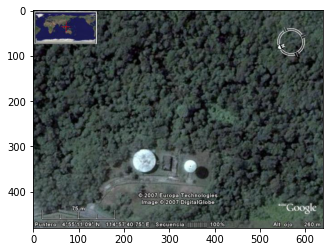

In [ ]:
plt.imshow(plt.imread(test_image), cmap=plt.cm.binary)
plt.show()